In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from functools import partial

import optuna
from sklearn.metrics import f1_score

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns

In [263]:
with open('./src/train.csv') as f:
    train = pd.read_csv(f)
with open('./src/test.csv') as f:
    test = pd.read_csv(f)

In [264]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

In [265]:
train.head(5)

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


<Axes: xlabel='preferred_difficulty_level', ylabel='count'>

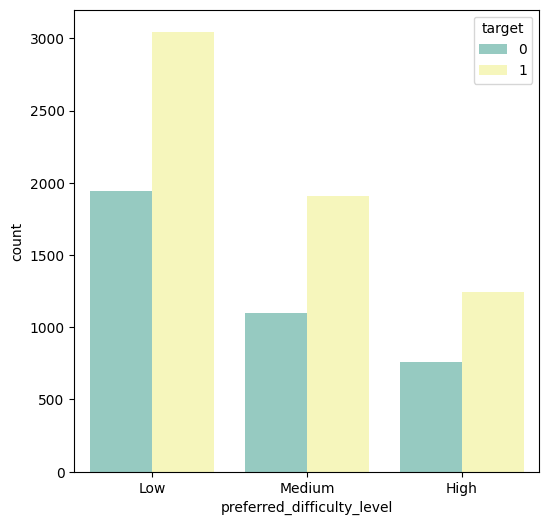

In [266]:
col = 'preferred_difficulty_level'
plt.figure(figsize = (6,6))
sns.countplot(data = train, x = col, hue = 'target', palette = 'Set3')
# plt.savefig(f'{col}.png')

In [299]:
# balance 맞추기
train[train['target']== 1].sample(3801)

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
8016,1,17,14.240286,32.733601,24,11,84.008846,1,4,High,Premium,4,1,1
6801,16,28,14.269720,77.500486,22,13,76.170468,1,2,High,Basic,4,3,1
1787,16,17,15.175640,6.388088,12,14,95.872653,2,4,High,Basic,3,0,1
5481,14,3,13.230447,93.880321,14,15,85.962084,3,5,Low,Basic,2,3,1
6386,6,26,13.243587,4.787153,12,14,44.067469,2,3,Low,Basic,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665,8,15,16.111136,81.946118,4,6,52.527111,0,4,Medium,Basic,3,1,1
6336,2,3,16.544514,15.149410,8,12,87.501586,1,4,Low,Basic,0,7,1
2681,19,10,22.214566,75.096336,11,18,66.864197,2,3,Medium,Premium,2,7,1
1577,5,1,13.404188,67.365554,16,16,75.078844,2,5,Low,Premium,1,7,1


In [267]:
train = train.drop(columns='user_id')
test = test.drop(columns = 'user_id')
train

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,22,29,14.727623,84.053558,18,16,64.966803,2,5,Low,Premium,1,1,1
9996,10,11,19.374054,45.464833,9,8,82.750244,3,3,Medium,Basic,2,7,1
9997,7,27,18.240978,127.302411,24,14,81.567839,3,5,High,Basic,1,6,1
9998,11,7,18.783800,5.297234,10,10,89.885656,4,5,Low,Basic,2,0,1


In [268]:
# 근 3개월 간 구독 개월
train.payment_pattern = train.payment_pattern.apply(lambda x: 0 if x == 0 else (1 if x in [1,2,4] else (2 if x in [3,5,6] else 3)))

# 근 1개월 구독 여부
# train.payment_pattern = train.payment_pattern.apply(lambda x: 0 if x in [0,2,4,6] else 1)

# 선호 학습 난이도 (high / basic,low)
# train.preferred_difficulty_level = train.preferred_difficulty_level.apply(lambda x: 1 if x == 'High' else 0)

In [269]:

train.payment_pattern = train.payment_pattern.astype('object', copy = False)
test.payment_pattern = test.payment_pattern.astype('object')
train.payment_pattern.value_counts()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subscription_duration              10000 non-null  int64  
 1   recent_login_time                  10000 non-null  int64  
 2   average_login_time                 10000 non-null  float64
 3   average_time_per_learning_session  10000 non-null  float64
 4   monthly_active_learning_days       10000 non-null  int64  
 5   total_completed_courses            10000 non-null  int64  
 6   recent_learning_achievement        10000 non-null  float64
 7   abandoned_learning_sessions        10000 non-null  int64  
 8   community_engagement_level         10000 non-null  int64  
 9   preferred_difficulty_level         10000 non-null  object 
 10  subscription_type                  10000 non-null  object 
 11  customer_inquiry_history           10000 non-null  int6

In [270]:
# # 특정 컬럼들에 대한 이상치 확인 (이상치가 있는 컬럼들을 리스트로 지정)
# columns_of_interest = ['average_login_time', 'total_completed_courses', 'recent_learning_achievement','abandoned_learning_sessions','customer_inquiry_history']  # 실제 컬럼 이름에 맞게 수정
# # 각 컬럼에 대해 이상치를 제외한 나머지 행 유지
# for column in columns_of_interest:
#     Q1 = train[column].quantile(0.25)
#     Q3 = train[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     train = train[(train[column] >= lower_bound) & (train[column] <= upper_bound)]
# # 결과 출력
# print("제거 전 행의 개수:", len(pd.read_csv('./src/train.csv')))
# print("제거 후 행의 개수:", len(train))

In [271]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X = pd.get_dummies(X)
y
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=39)

0       0
1       1
2       1
3       1
4       1
       ..
9995    1
9996    1
9997    1
9998    1
9999    0
Name: target, Length: 10000, dtype: int64

In [272]:
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier()
# model.fit(X,y)
# model.feature_importances_
# df = pd.DataFrame({'idx': X.columns, 'imp' : model.feature_importances_})
# df = df.sort_values(by = 'imp', ascending = False)
# df

In [273]:
# kf = KFold(n_splits=10, shuffle=True, random_state=39)
# macrof1 = []
# model = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth= 13, min_samples_split= 10, random_state= 39)
# fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (18,25))
# for idx, (train_idx, val_idx) in enumerate(kf.split(X,y)):
#     print(f"fold: {idx}")
#     X_train = X.iloc[train_idx,:]
#     X_val = X.iloc[val_idx,:]
#     y_train = y.iloc[train_idx]
#     y_val = y.iloc[val_idx]

#     model.fit(X_train, y_train)
#     prediction = model.predict(X_val)
#     macrof1.append(f1_score(y_val, prediction, average = 'macro'))
#     tmp = pd.DataFrame({'idx': X.columns, 'imp' : model.feature_importances_})
#     tmp = tmp.sort_values(by = 'imp', ascending = False)
#     sns.barplot(y = X_train.columns, x = model.feature_importances_, ax = ax[idx//2][idx%2], order = tmp['idx'])
# plt.show()
# print(macrof1)
# print(np.mean(macrof1))

In [300]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators = 200, colsample_bynode = 0.8, max_depth = 13, learning_rate = 0.3, reg_lambda = 1)
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=39)
macrof1 = []
feat_imp = []
X_copy = X.copy()
# X_copy = X_copy.drop(columns = ['preferred_difficulty_level_High','preferred_difficulty_level_Low','preferred_difficulty_level_Medium','payment_pattern','total_completed_courses','abandoned_learning_sessions','subscription_type_Basic','subscription_type_Premium'])
# X_copy = X_copy[['average_login_time','average_time_per_learning_session']]


fold : 0
fold : 1
fold : 2
fold : 3
fold : 4
fold : 5
fold : 6
fold : 7
fold : 8
fold : 9


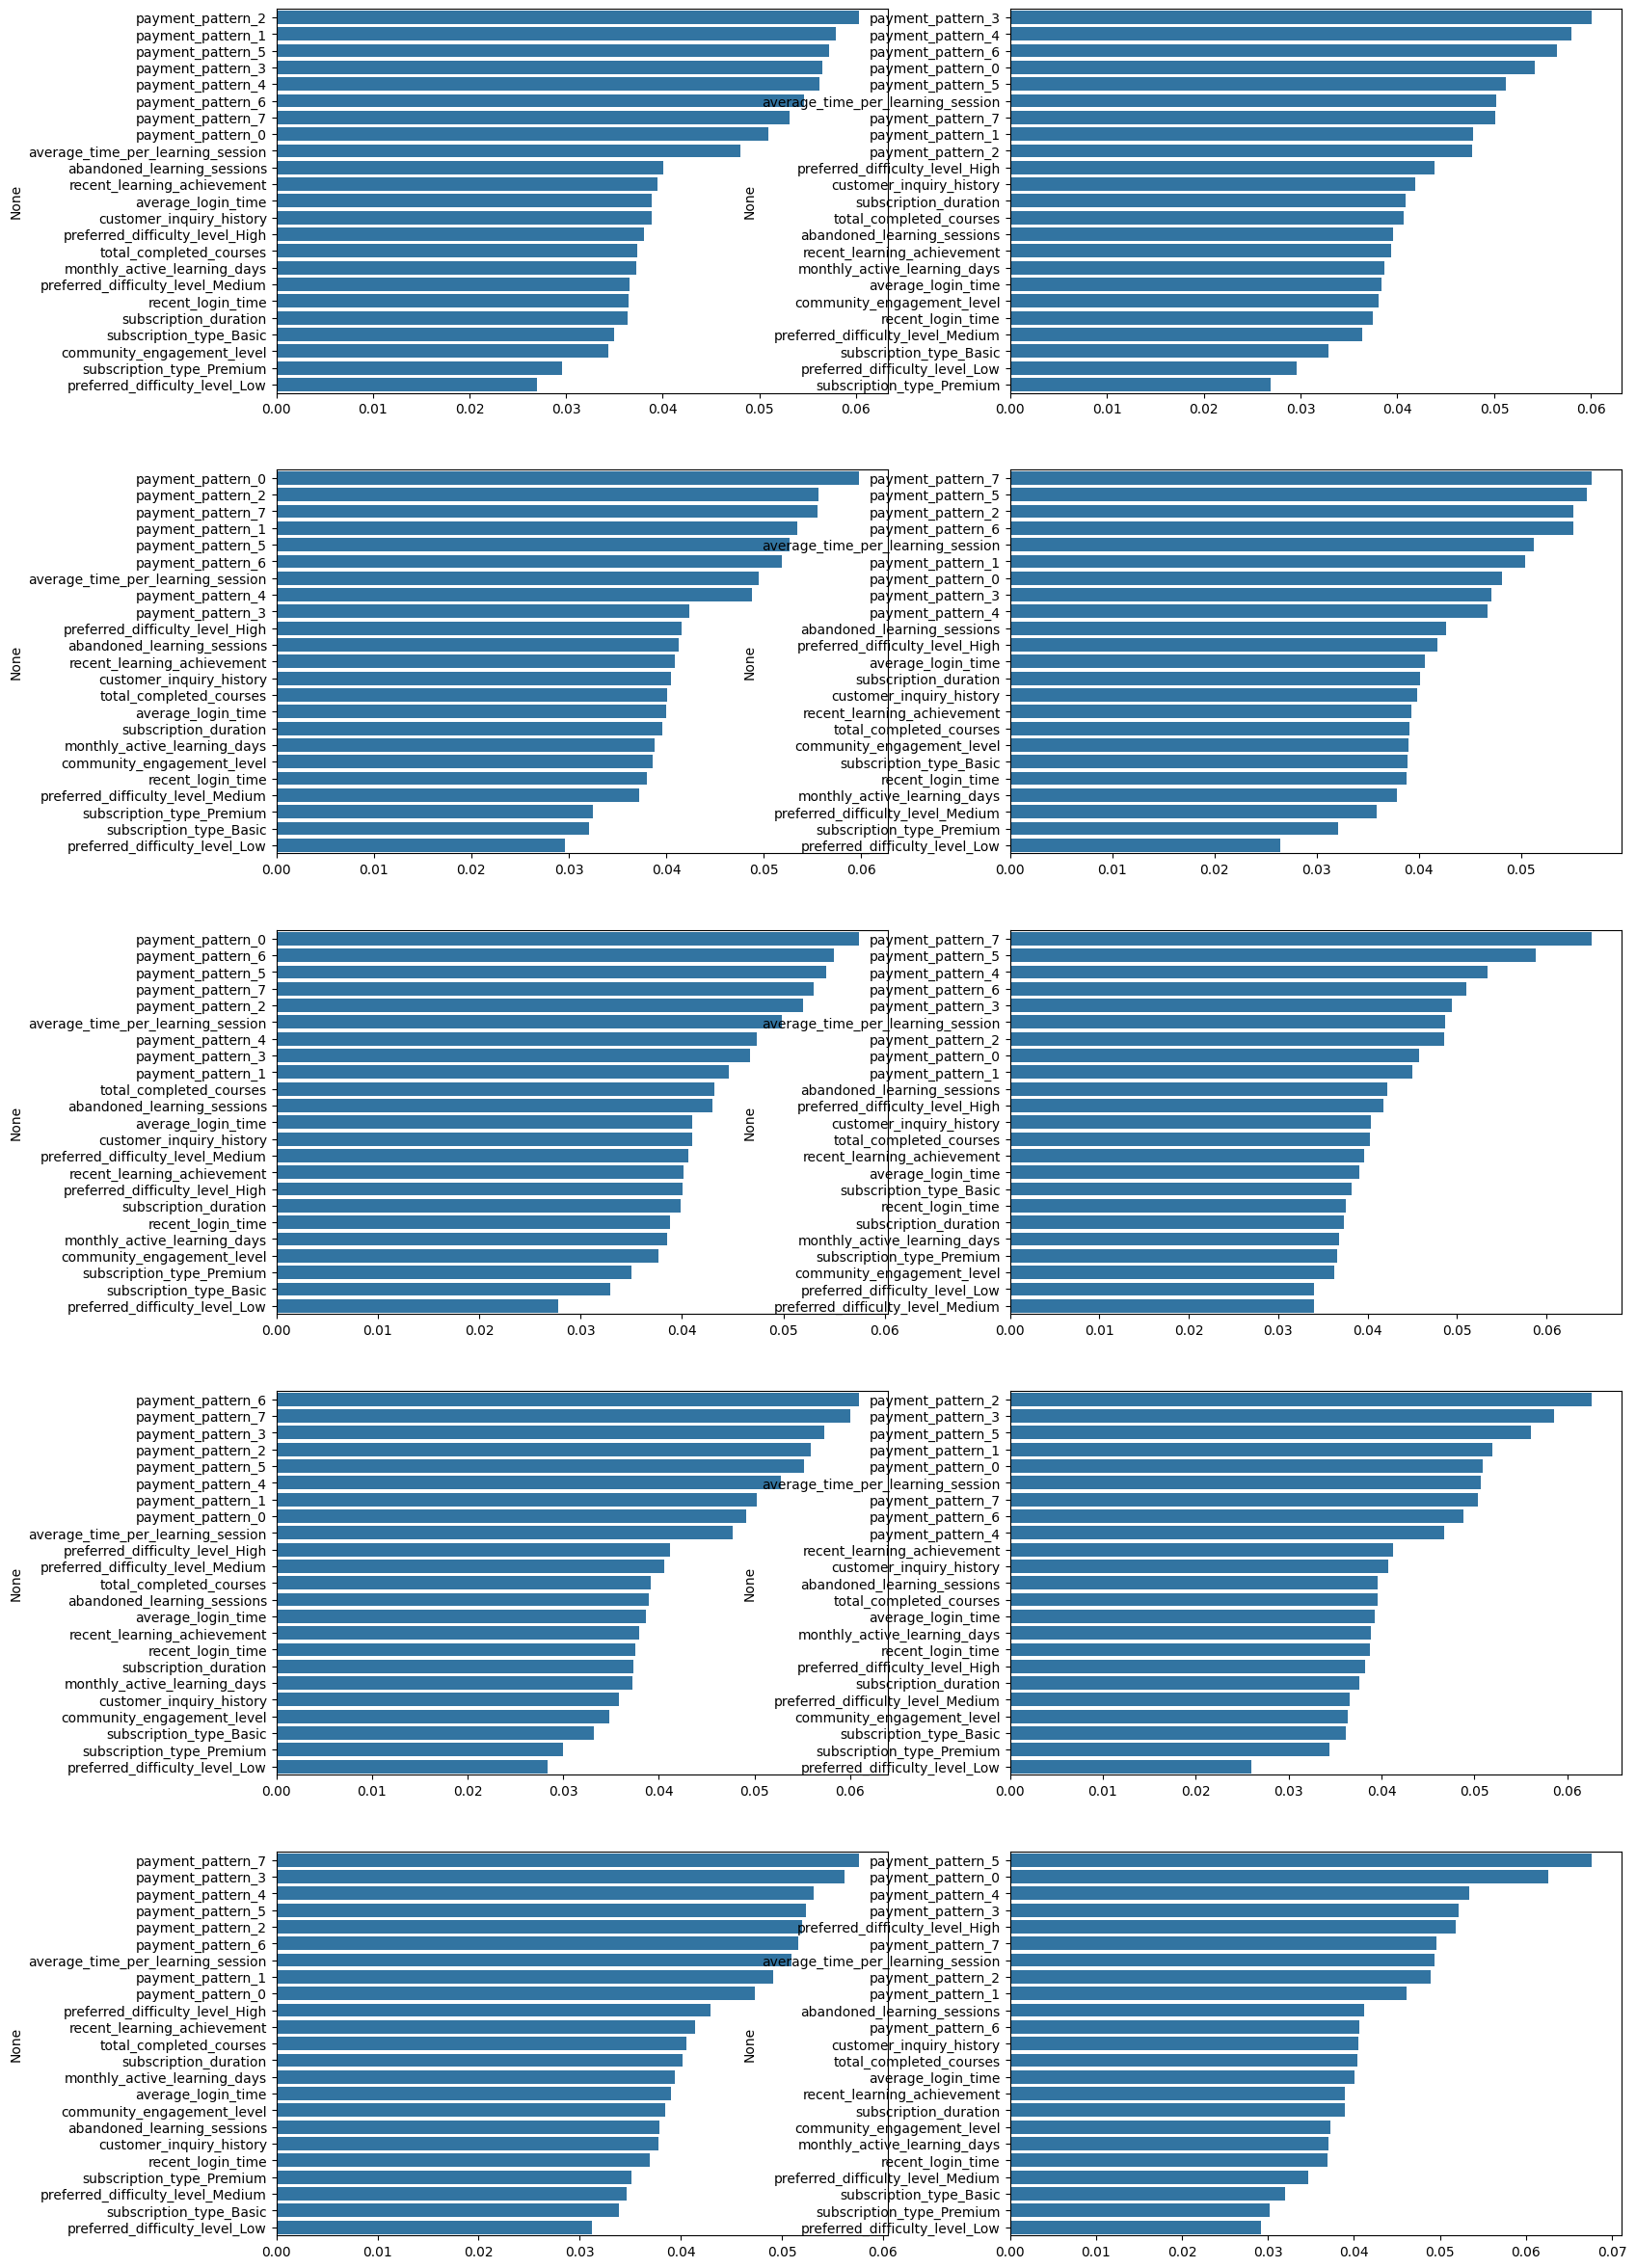

[0.5013924527842974, 0.511333056645201, 0.5098901098901099, 0.49423393187900466, 0.5255769205308243, 0.5188105783111233, 0.5136422255379645, 0.4811924126285782, 0.510391300426475, 0.4950009573706905]
macro f1 score : 0.5061463946004269


,feat,imp
20,payment_pattern_5,0.056185
22,payment_pattern_7,0.055151
17,payment_pattern_2,0.053877
18,payment_pattern_3,0.052651
15,payment_pattern_0,0.052607
21,payment_pattern_6,0.052594
19,payment_pattern_4,0.051662
16,payment_pattern_1,0.049659
3,average_time_per_learning_session,0.049618
10,preferred_difficulty_level_High,0.042128


In [301]:
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (18, 30))
for idx, (train_idx, val_idx) in enumerate(kf.split(X_copy, y)):
    print(f"fold : {idx}")
    X_train = X_copy.iloc[train_idx,:]
    X_val = X_copy.iloc[val_idx,:]
    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]

    class_0_count = (y_train == 0).sum()
    class_1_count = (y_train == 1).sum()
    weight_value = class_0_count / class_1_count
    model.set_params(scale_pos_weight = weight_value)

    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    macrof1.append(f1_score(y_val, prediction, average = 'macro'))
    feat_imp.append(model.feature_importances_)
    tmp = pd.DataFrame({'idx': X_copy.columns, 'imp' : model.feature_importances_})
    tmp = tmp.sort_values(by = 'imp', ascending = False)
    sns.barplot(y = X_train.columns,x =  model.feature_importances_, ax = ax[idx//2][idx%2], order = tmp['idx'])
plt.show()
print(macrof1)
print(f"macro f1 score : {np.mean(macrof1)}")
pd.DataFrame({'feat': X_train.columns, 'imp' : sum(feat_imp)/K}).sort_values(by = 'imp', ascending=False)
        

In [297]:
with open('./src/sample_submission.csv') as f:
    submission = pd.read_csv(f)

pred = model.predict(pd.get_dummies(test))
submission.target = pred
submission.to_csv('./src/submission.csv', index=False)